This notebook show the procedure of fitting a gaussian distribution with MCMC.

Given the mean $\mu$ and std $\sigma$, the likelihood of observing $x$ is 

$$ P\left(x|\mu,\sigma \right)= \frac{1}{\sqrt{2\pi}\sigma} \exp\left( -\frac{\left(x-\mu\right)^2}{2\sigma^2} \right)$$


If you have many $x$s, simply multiply them. In practice, better use log form. The log of likelihood is 

$$ \log P\left(x|\mu,\sigma \right)= -0.5*\log\left(2\pi\right)-\log\left(\sigma\right)  -\frac{\left(x-\mu\right)^2}{2\sigma^2}  $$

In [4]:
#simulate gaussian data
np.random.seed()

mu_sim=20,
std_sim=5,
####### 
simData=np.random.normal(mu_sim,std_sim,2000)

In [33]:
#assmuing we do not inow mu_sim and std_sim.

def getlogp(data,mu,istd):
    logp=-0.5*np.log(2*np.pi)+0.5*np.log(istd**2)-(data-mu)**2/2.*istd**2
    
    return np.sum(logp)


In [12]:
getlogp(simData,1,3)

-17352945.279923722

In [66]:
#the MCMC part

mu0=np.random.exponential(2)
istd0=np.random.exponential(1)

P0=getlogp(simData,mu0,istd0)

muList= [mu0]
istdList=[ istd0]

 
 
for i in range(100000):
    muCand=muList[-1]+np.random.normal(0,2)

    istdCand=istdList[-1]+np.random.normal(0,1)
    
    if istdCand<0: #we only want positive values
        continue
    
    P1=getlogp(simData,muCand,istdCand)
    
    u=np.random.uniform(0,1)

    if P1>P0 or P1-P0>np.log(u):
        #accept
        P0=P1
        print muCand,1./istdCand
        muList.append(muCand)
        istdList.append(istdCand)
    else:
        #jrect
        continue
        muList.append(muList[-1])
        istdList.append(istdList[-1])
burn_in=100
goodMu=np.array(muList[burn_in:])
istdList=1./np.array(istdList[burn_in:])

print len(muList)
print "Done"

-0.930066879696 68.4468423769
1.00039671555 12.0288296518
-0.555796431884 15.3958917191
-0.467387359059 23.5615438636
0.562778374766 18.2917526224
2.57335928676 14.3193904577
3.71186305771 21.6972729706
5.43357939827 12.6462581464
6.38134487803 13.8492029222
9.99471048482 14.623008312
10.1314075182 14.4817687205
13.0728910335 10.619948138
16.9160576304 11.8299003101
18.7272930353 5.1514645195
20.0662695629 5.87329543785
20.6616246627 4.8114550269
19.8263457867 4.66434473544
20.2827629714 4.88167798364
20.0137379833 5.19349399947
20.0453358224 5.03963044861
20.0610174683 4.98594617257
20.0107018101 4.92494463677
20.0045682439 4.98673667713
19.9788576467 5.01743477809
20.0438675834 5.00619559514
19.9768257792 4.9889383386
20.0405810083 4.95405581471
20.007397 4.99292735743
20.1072167189 4.97276981327
20.0474293408 4.91048845062
19.9963915928 5.06821398041
20.0669462396 4.92448211725
19.9474971141 4.96469272861
19.9673057611 5.00196374131
19.9410728353 4.97393754679
19.9978252858 4.932220

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

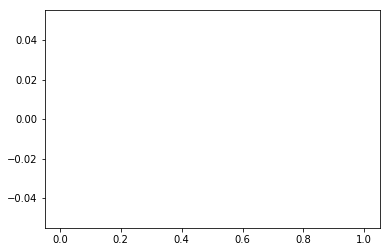

In [67]:
plt.hist(goodMu)